In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from geopy.distance import geodesic

Import first 6M rows from the training set

In [3]:
train = pd.read_csv("./data/train.csv", nrows=6000000)

The data consists of eight features:
    1. key
    2. fare_amount
    3. pickup_datetime
    4. pickup_longitude
    5. pickup_latitude
    6. dropoff_longitude
    7. dropoff_latitude
    8. passenger_count
    
**key** is for identification.

**fare_amount** is the target value we will be predicting for the test set.

Rest of the properties are the input features based on which we need to predict the fare amount.

In [80]:
print("First five rows of the training data:\n\n")
train.head()

First five rows of the training data:




,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,...,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_LaGuardia,is_dropoff_LaGuardia,trip_distance,pickup_borough,dropoff_borough,is_pickup_in_lower_manhattan,is_dropoff_in_lower_manhattan
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,...,0,0,0,0,0,0.640487,queens,queens,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,...,0,0,0,0,0,5.250670,manhattan,manhattan,1,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,...,0,0,0,0,0,0.863411,manhattan,manhattan,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,...,0,0,0,0,0,1.739386,manhattan,manhattan,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,...,0,0,0,0,0,1.242218,manhattan,manhattan,0,0


Study the information available in the training set

In [5]:
print("Columns of the training data:\n\n")
train.info()

Columns of the training data:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 366.2+ MB


Create new columns based on date and time

In [6]:
# Convert pickup_datetime to datetime object with format Y-m-d H:M:S
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'],
                            format='%Y-%m-%d %H:%M:%S UTC')

print("Training set after conversion:\n\n")
train.head()

Training set after conversion:




,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
def create_date_columns():
    """
        Create new rows from pickup_datetime, 
        namely, date, day, hour, day_of_week, month and year
    """
    # Get datetime.date objects and create a new column pickup_date
    train['pickup_date'] = train['pickup_datetime'].dt.date
    train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
    train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
    train['pickup_day_of_week'] = train['pickup_datetime'] \
                                        .apply(lambda x: calendar.day_name[x.weekday()])
    train['pickup_month'] = train['pickup_datetime'].apply(lambda x: x.month)
    train['pickup_year'] = train['pickup_datetime'].apply(lambda x: x.year)
    

In [8]:
create_date_columns()

In [9]:
print("New features in the training set::\n\n")
train.head()

New features in the training set::




,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,17,Monday,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,16,Tuesday,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,0,Thursday,8,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,4,Saturday,4,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,7,Tuesday,3,2010


Check for null entries in the train data set

In [10]:
# Check if there are any missing values in the data
train[pd.isnull(train)].sum()

key                   0.0
fare_amount           0.0
pickup_datetime       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
passenger_count       0.0
pickup_date           0.0
pickup_day            0.0
pickup_hour           0.0
pickup_day_of_week    0.0
pickup_month          0.0
pickup_year           0.0
dtype: float64

There are no null entries in the training set.

### Analysis of Fare Amount data distribution

Text(0.5,1,'Distribution of fare amount')

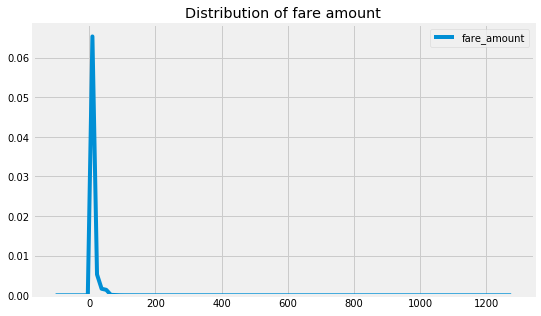

In [11]:
# Visualisation of distribution of fare_amount
plt.figure(figsize=(8, 5))

# Plot kernel density estimate (probability density function) for fare_amount
sns.kdeplot(train['fare_amount']).set_title("Distribution of fare amount")

As we can see there are some fare amount values less than zero. So, we need to remove them from the training set as negative fare amounts don't make any sense.

In [12]:
# Find negative fare amounts
print("Number of records with negative fare amounts = ", 
      train.loc[train['fare_amount'] < 0].shape[0])

Number of records with negative fare amounts =  262


In [13]:
train = train.loc[train['fare_amount'] >= 0]

print("Number of trips with positive fare amount = ", train.shape[0])

Number of trips with positive fare amount =  5999738


Another observation that we can make from the above plot is that, the graph is highly skewed. To make it close to a normal distribution, we can do a log transformation of the fare amount and plot it again.

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5,1,'Distribution of fare amount (log transformation)')

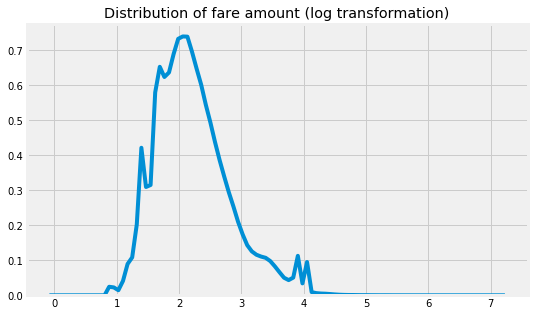

In [14]:
plt.figure(figsize=(8, 5))
log_fare_amounts = np.nan_to_num(np.log(train['fare_amount']))
log_fare_amounts = log_fare_amounts[log_fare_amounts >= 0]
sns.kdeplot(log_fare_amounts).set_title("Distribution of fare amount (log transformation)")

### Analysis for trip fare based on pick up and drop off Latitudes and Longitudes

In [15]:
# We analyse the range of pick up coordinates and drop off coordinates for the training set
print("Range of coordinates for training set\n")
print("-------------------------------------------")
print("Range of Pickup Latitude is ", 
      (min(train['pickup_latitude']), max(train['pickup_latitude'])))
print("Range of Dropoff Latitude is ", 
      (min(train['dropoff_latitude']), max(train['dropoff_latitude'])))
print("Range of Pickup Longitude is ", 
      (min(train['pickup_longitude']), max(train['pickup_longitude'])))
print("Range of Dropoff Longitude is ", 
      (min(train['dropoff_longitude']), max(train['dropoff_longitude'])))


Range of coordinates for training set

-------------------------------------------
Range of Pickup Latitude is  (-3488.079513, 3344.459268)
Range of Dropoff Latitude is  (-3488.079513, 3345.9173530000003)
Range of Pickup Longitude is  (-3426.60895, 3439.425565)
Range of Dropoff Longitude is  (-3412.6530869999997, 3457.62235)


The central coordinates for New York are (40.771133, -73.974187). From the above information we can clearly conclude that there are a lot of outliers which we need to filter out.

In [16]:
# Let's try to analyze the test data and find out the boundaries.
test =  pd.read_csv('./data/test.csv')
# We analyse the range of pick up coordinates and drop off coordinates for the testing set
print("Range of coordinates for testing set\n\n")
print("-------------------------------------------")
print("Range of Pickup Latitude is ", 
      (min(test['pickup_latitude']), max(test['pickup_latitude'])))
print("Range of Dropoff Latitude is ", 
      (min(test['dropoff_latitude']), max(test['dropoff_latitude'])))
print("Range of Pickup Longitude is ", 
      (min(test['pickup_longitude']), max(test['pickup_longitude'])))
print("Range of Dropoff Longitude is ", 
      (min(test['dropoff_longitude']), max(test['dropoff_longitude'])))


Range of coordinates for testing set


-------------------------------------------
Range of Pickup Latitude is  (40.573143, 41.709555)
Range of Dropoff Latitude is  (40.568973, 41.696683)
Range of Pickup Longitude is  (-74.252193, -72.986532)
Range of Dropoff Longitude is  (-74.263242, -72.990963)


As we can see the coordinates of the test data are very much limited to the central coordinates of New York. Thus, we can remove all outliers from the train data as well based on the boundaries of the test data.

In [17]:
# Set boundary for pick up locations
boundary_pick_up = {      
    'min_lat': 40.568973,
    'min_lng': -74.263242, 
    'max_lat': 41.709555,
    'max_lng': -72.986532
}

In [18]:
# There are chances of coordinates set to 0 in training data. 
zero_locations = train[(train.pickup_latitude==0) | 
      (train.pickup_longitude)==0 | 
      (train.dropoff_latitude==0) |
      (train.dropoff_longitude==0)]

print("Number of records with pickup/dropoff location having latitude/longitude as 0 = ",
     zero_locations.shape[0])

Number of records with pickup/dropoff location having latitude/longitude as 0 =  114137


In [19]:
train.loc[~(
    (train.pickup_longitude >= boundary_pick_up['min_lng']) & 
    (train.pickup_longitude <= boundary_pick_up['max_lng']) &
    (train.pickup_latitude >= boundary_pick_up['min_lat']) & 
    (train.pickup_latitude <= boundary_pick_up['max_lat']) &
    (train.dropoff_longitude >= boundary_pick_up['min_lng']) & 
    (train.dropoff_longitude <= boundary_pick_up['max_lng']) &
    (train.dropoff_latitude >= boundary_pick_up['min_lat']) & 
    (train.dropoff_latitude <= boundary_pick_up['max_lat'])),'is_outlier_loc'] = 1

train.loc[(
    (train.pickup_longitude >= boundary_pick_up['min_lng']) & 
    (train.pickup_longitude <= boundary_pick_up['max_lng']) &
    (train.pickup_latitude >= boundary_pick_up['min_lat']) & 
    (train.pickup_latitude <= boundary_pick_up['max_lat']) &
    (train.dropoff_longitude >= boundary_pick_up['min_lng']) & 
    (train.dropoff_longitude <= boundary_pick_up['max_lng']) &
    (train.dropoff_latitude >= boundary_pick_up['min_lat']) & 
    (train.dropoff_latitude <= boundary_pick_up['max_lat'])),'is_outlier_loc'] = 0

print("Outlier vs Non Outlier Counts\n")
print("Number of outliers in the training set based on the boundary of the test set = ",
      train['is_outlier_loc'].value_counts()[1])



Outlier vs Non Outlier Counts

Number of outliers in the training set based on the boundary of the test set =  128328


In [20]:
# We remove all rows where location is categorised as an outlier
train = train.loc[train['is_outlier_loc'] == 0]

# We can now safely remove the column is_outlier_loc
train.drop(['is_outlier_loc'], axis=1, inplace=True)

Next we try to visualize trips to and from the airports.

Coordinates of the three major airports in New York are as follows:

    1. Coordinates of Newark Airport = 40.6895° N, 74.1745° W

    2. Coordinates of JFK Airport = 40.6413° N, 73.7781° W

    3. Coordinates of La Guardia Airport = 40.7769° N, 73.8740° W

(-74.03, -73.75)

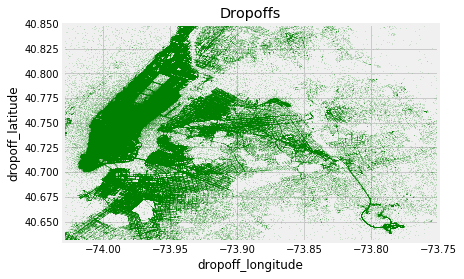

In [21]:
city_lat_border = (40.63, 40.85)
city_long_border = (-74.03, -73.75)

train.plot(
    kind='scatter', 
    x='dropoff_longitude', 
    y='dropoff_latitude',
    color='green', 
    s=.02, 
    alpha=.6
)

plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

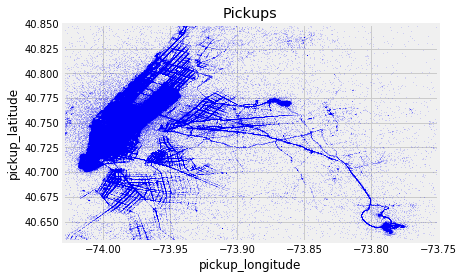

In [22]:
train.plot(kind='scatter',
           x='pickup_longitude', 
           y='pickup_latitude', 
           color='blue',  
           s=.02, alpha=.6)

plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

We can see heavy pickups and dropoffs near the three airports.

In [23]:
# Now we try to calculate the average fare across NYC based on lat and lng
pickup_fare_amount = train.groupby(['pickup_latitude','pickup_longitude'])['fare_amount'] \
                    .mean() \
                    .reset_index() \
                    .rename(columns={'fare_amount':'avg_fare'})
pickup_fare_amount.head()

,pickup_latitude,pickup_longitude,avg_fare
0,40.569048,-73.768605,12.9
1,40.569414,-74.025514,10.5
2,40.569518,-74.089760,8.9
3,40.569520,-74.018795,9.5
4,40.569605,-74.225293,8.9


In the above scatter plots, we saw high rate of pick up and drop off from the airports. But is it the same always? Also how does the fare vary from time to time across the airports? Let's try to figure it out for the JFK airport.

In [26]:
JFK = {
    'min_lng': -73.8352, 
    'min_lat': 40.6195, 
    'max_lng': -73.7401,  
    'max_lat': 40.6659
}


JFK_center=[40.6437, -73.7900]

# Get all pickups from JFK
JFK_pickup = train.loc[(train.pickup_latitude >= JFK['min_lat']) & 
                     (train.pickup_latitude <= JFK['max_lat'])]
JFK_pickup = JFK_pickup.loc[(train.pickup_longitude >= JFK['min_lng']) & 
                      (train.pickup_longitude <= JFK['max_lng'])]

print("Number of trips with pickups from JFK", JFK_pickup.shape[0])

# Get all dropoffs at JFK
JFK_dropoff = train.loc[(train.dropoff_latitude >= JFK['min_lat']) & 
                        (train.dropoff_latitude <= JFK['max_lat'])]
JFK_dropoff = JFK_dropoff.loc[(train.dropoff_longitude>=JFK['min_lng']) & 
                              (train.dropoff_longitude<=JFK['max_lng'])]

print("Number of trips with dropoffs at JFK", JFK_dropoff.shape[0])

Number of trips with pickups from JFK 90199
Number of trips with dropoffs at JFK 45609


Now we find the average fare for trips to/from JFK

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


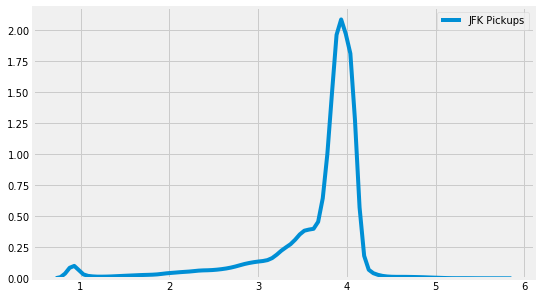

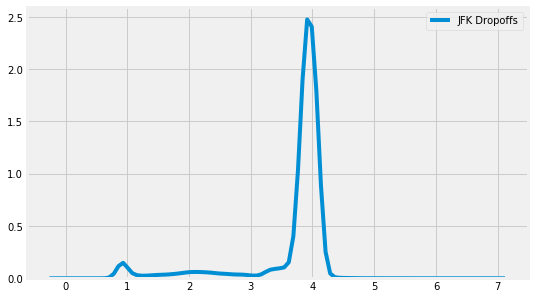

In [27]:
plt.figure(figsize=(8,5))
log_JFK_pickup_fare_amounts = np.nan_to_num(np.log(JFK_pickup['fare_amount'].values))
log_JFK_pickup_fare_amounts = log_JFK_pickup_fare_amounts[log_JFK_pickup_fare_amounts >= 0]
sns.kdeplot(log_JFK_pickup_fare_amounts, label='JFK Pickups')

plt.figure(figsize=(8,5))
log_JFK_dropoff_fare_amounts = np.nan_to_num(np.log(JFK_dropoff['fare_amount'].values))
log_JFK_dropoff_fare_amounts = log_JFK_dropoff_fare_amounts[log_JFK_dropoff_fare_amounts >= 0]
sns.kdeplot(log_JFK_dropoff_fare_amounts, label='JFK Dropoffs')

Now we try to compare average fare for trips to/from JFK to average fare for all trips

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Fare Amount Distribution')

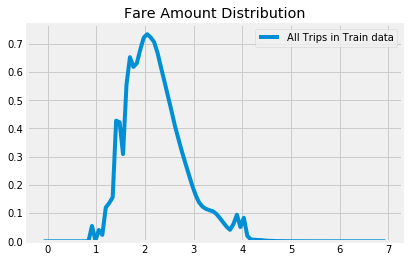

In [28]:
log_fare_amounts = np.nan_to_num(np.log(train['fare_amount'].values))
log_fare_amounts = log_fare_amounts[log_fare_amounts >= 0]

sns.kdeplot(log_fare_amounts, label='All Trips in Train data')
plt.title("Fare Amount Distribution")

Thus, the average fare amount is much higher when pickup or dropoff is related to JFK airport.

So, now we create a function to identify whether a trip is related to the airport or not.

In [29]:
# Dictionary of lat-lngs for the three airports:
nyc_airports = {
    'JFK': {
        'min_lng': -73.8352, 
        'min_lat': 40.6195,
        'max_lng': -73.7401,  
        'max_lat': 40.6659
    },     
    'EWR': {
        'min_lng': -74.1925,
        'min_lat': 40.6700, 
        'max_lng': -74.1531, 
        'max_lat': 40.7081
    },
    'LaGuardia': {
        'min_lng': -73.8895, 
        'min_lat': 40.7664, 
        'max_lng': -73.8550, 
        'max_lat': 40.7931
    }
}

In [30]:
def isTripRelatedToAirport(latitude,longitude,airport_name='JFK'):
    """
    Check whether trip is related to the airport
    Args:
        latitude: Floating point integer denoting the latitude of the pickup/dropoff point
        longitude: Floating point integer denoting the longitude 
                    of the pickup/dropoff point
        airport_name: Name of the airport
    Returns:
        Either 0 or 1 indicating whether trip is related to one of the airports
    """
    
    if (latitude >= nyc_airports[airport_name]['min_lat'] and 
        latitude <= nyc_airports[airport_name]['max_lat'] and 
        longitude >= nyc_airports[airport_name]['min_lng'] and 
        longitude <= nyc_airports[airport_name]['max_lng']):
        return 1
    else:
        return 0

Now we create 6 new columns related to trips to the three airports JFK, EWR, 
and La Guardia respectively.

In [31]:
# Columns indicating trips to/from JFK
train['is_pickup_JFK'] = train.apply(lambda record: 
                                     isTripRelatedToAirport(
                                         record['pickup_latitude'],
                                         record['pickup_longitude'],
                                         'JFK'), axis=1)
train['is_dropoff_JFK'] = train.apply(lambda record: 
                                      isTripRelatedToAirport(
                                          record['dropoff_latitude'],
                                          record['dropoff_longitude'],
                                          'JFK'), axis=1)

In [32]:
# Columns indicating trips to/from EWR
train['is_pickup_EWR'] = train.apply(lambda record: 
                                     isTripRelatedToAirport(
                                         record['pickup_latitude'],
                                         record['pickup_longitude'],
                                         'EWR'), axis=1)
train['is_dropoff_EWR'] = train.apply(lambda record: 
                                      isTripRelatedToAirport(
                                          record['dropoff_latitude'],
                                          record['dropoff_longitude'],
                                          'EWR'), axis=1)

In [33]:
# Columns indicating trips to/from JFK
train['is_pickup_LaGuardia'] = train.apply(lambda record: 
                                     isTripRelatedToAirport(
                                         record['pickup_latitude'],
                                         record['pickup_longitude'],
                                         'LaGuardia'), axis=1)
train['is_dropoff_LaGuardia'] = train.apply(lambda record: 
                                      isTripRelatedToAirport(
                                          record['dropoff_latitude'],
                                          record['dropoff_longitude'],
                                          'LaGuardia'), axis=1)

In [34]:
print("The training data set now looks as follows\n")
print("--------------------------------------------")
train.head()

The training data set now looks as follows

--------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_LaGuardia,is_dropoff_LaGuardia
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,17,Monday,6,2009,0,0,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,16,Tuesday,1,2010,0,0,0,0,0,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,0,Thursday,8,2011,0,0,0,0,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,4,Saturday,4,2012,0,0,0,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,7,Tuesday,3,2010,0,0,0,0,0,0


### Analysis for  trip fare based on trip distance

In [48]:
def trip_distance(lat1, lat2, lon1, lon2):
    """
    Calculate trip distance based on Haversine formula
    Args:
        lat1: Latitude of first point
        lat2: Latitude of second point
        lon1: Longitude of first point
        lon2: :ongitude of second point
    Returns:
        Distance between the two points in miles
    """
    # pi / 180
    p = 0.017453292519943295
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

Create a new column named trip_distance which will contain the trip distance for each record.

In [36]:
train['trip_distance'] = train.apply(lambda record: 
                                     trip_distance(
                                         record['pickup_latitude'],
                                         record['dropoff_latitude'],
                                         record['pickup_longitude'],
                                         record['dropoff_longitude']
                                     ),axis=1)

In [37]:
print("The training data set now looks as follows\n")
print("--------------------------------------------")
train.head()

The training data set now looks as follows

--------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,...,pickup_day_of_week,pickup_month,pickup_year,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_LaGuardia,is_dropoff_LaGuardia,trip_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,...,Monday,6,2009,0,0,0,0,0,0,0.640487
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,...,Tuesday,1,2010,0,0,0,0,0,0,5.250670
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,...,Thursday,8,2011,0,0,0,0,0,0,0.863411
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,...,Saturday,4,2012,0,0,0,0,0,0,1.739386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,...,Tuesday,3,2010,0,0,0,0,0,0,1.242218


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Distribution of Trip Distance (log scale)')

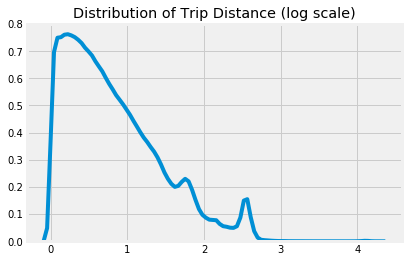

In [38]:
log_trip_distance = np.nan_to_num(np.log(train['trip_distance'].values))
log_trip_distance = log_trip_distance[log_trip_distance >= 0]
sns.kdeplot(log_trip_distance).set_title("Distribution of Trip Distance (log scale)")

As we can see from the scatter plot above, trips within 0 to 1 mile have the highest distribution.

Now we generate a scatter plot of Trip distance vs Fare amount.

Text(0,0.5,'Fare Amount')

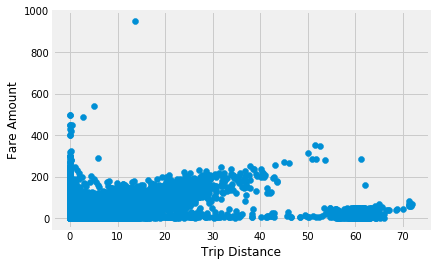

In [39]:
plt.scatter(x = train['trip_distance'],
            y = train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")

From the scatter plot, we conclude that the fare seems to be approximately fixed for trip distances > 50 miles. Assuming airports pickup or dropoff to have fixed prices, we can remove the trips related to airport pickup and dropoff and plot the distribution of Fare Amount vs Trip distribution again.

In [43]:
non_airport_trips = train.loc[(train['is_dropoff_JFK'] == 0) & 
                              (train['is_dropoff_EWR'] == 0) & 
                              (train['is_dropoff_LaGuardia'] == 0) &
                              (non_airport_trips['is_pickup_JFK']==0) & 
                              (non_airport_trips['is_pickup_EWR']==0) & 
                              (non_airport_trips['is_pickup_LaGuardia']==0)]

non_airport_trips.shape

(5547344, 21)

We will now try to visualize the non-airport trips only.

Text(0.5,1,'Trip Distance vs Fare Amount (excluding airport rides)')

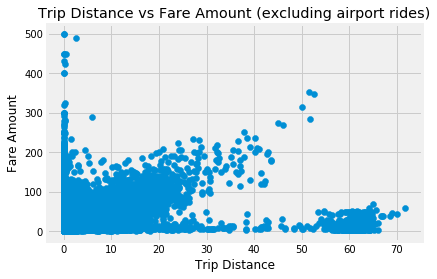

In [44]:
plt.scatter(x = non_airport_trips['trip_distance'],
            y = non_airport_trips['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport rides)")

As we can see in the scatter plot above, the cluster for trip distance greater than 50 miles still exists. So, we will try to visualize the pick-up or drop-off or both locations for these trips for better examining the situation.

In [47]:
non_airport_long_trips = non_airport_trips[non_airport_trips['trip_distance'] >= 50]
non_airport_long_trips.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,...,pickup_day_of_week,pickup_month,pickup_year,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_LaGuardia,is_dropoff_LaGuardia,trip_distance
1684,2009-05-02 19:01:01.0000002,2.50,2009-05-02 19:01:01,-73.137393,41.366138,-73.996510,40.745320,2,2009-05-02,2,...,Saturday,5,2009,0,0,0,0,0,0,61.995186
3075,2009-01-06 10:53:36.0000004,6.90,2009-01-06 10:53:36,-73.137393,41.366138,-73.974598,40.751311,1,2009-01-06,6,...,Tuesday,1,2009,0,0,0,0,0,0,60.885112
4487,2009-08-26 07:43:16.0000001,4.90,2009-08-26 07:43:16,-73.137393,41.366138,-73.957685,40.765644,1,2009-08-26,26,...,Wednesday,8,2009,0,0,0,0,0,0,59.559694
5663,2009-02-25 07:05:05.0000003,49.15,2009-02-25 07:05:05,-73.137393,41.366138,-74.000940,40.731723,1,2009-02-25,25,...,Wednesday,2,2009,0,0,0,0,0,0,62.817285
7401,2009-07-16 09:41:26.0000001,4.50,2009-07-16 09:41:26,-73.900571,40.764047,-73.137393,41.366138,1,2009-07-16,16,...,Thursday,7,2009,0,0,0,0,0,0,57.542607


In [51]:
mean_non_airport_pick_up_latitude = non_airport_long_trips['pickup_latitude'].mean()
mean_non_airport_pick_up_longitude = non_airport_long_trips['pickup_longitude'].mean()

In [56]:
drop_map = folium.Map(location = [mean_non_airport_pick_up_latitude,
                                  mean_non_airport_pick_up_longitude],
                      zoom_start = 5)

for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude'], row['dropoff_longitude']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']],
                        radius=3,
                        
                        color="blue", 
                        fill_opacity=0.9
                       ).add_to(drop_map)

drop_map

It's still not pretty clear what's happening here. It seems like trips are mostly distributed across lower Manhattan.
With some research, we realised that New York City encompasses five county-level administrative divisions called boroughs: The Bronx, Brooklyn, Manhattan, Queens, and Staten Island. So, let's try to visualise the data by grouping into each borough.

In [57]:
nyc_boroughs = {
    'manhattan': {
        'min_lng': -74.0479,
        'min_lat': 40.6829,
        'max_lng': -73.9067,
        'max_lat': 40.8820
    },
    'queens': {
        'min_lng': -73.9630,
        'min_lat': 40.5431,
        'max_lng': -73.7004,
        'max_lat': 40.8007
    },
    'brooklyn': {
        'min_lng': -74.0421,
        'min_lat': 40.5707,
        'max_lng': -73.8334,
        'max_lat': 40.7395
    },
    'bronx': {
        'min_lng': -73.9339,
        'min_lat': 40.7855,
        'max_lng': -73.7654,
        'max_lat': 40.9176
    },
    'staten_island': {
        'min_lng': -74.2558,
        'min_lat': 40.4960,
        'max_lng': -74.0522,
        'max_lat': 40.6490
    }
}

In [58]:
def getBorough(lat,lng):
    """
    Get the borough based on latitude and longitude
    Args:
        lat: Latitude of the place
        lng: Longitude of the place
    Returns:
        A string representing the name of the borough
    """
    locations = nyc_boroughs.keys()
    for location in locations:
        if (lat >= nyc_boroughs[location]['min_lat'] and 
            lat <= nyc_boroughs[location]['max_lat'] and 
            lng >= nyc_boroughs[location]['min_lng'] and 
            lng <= nyc_boroughs[location]['max_lng']):
            return location
    return 'others'

Now we create two new columns pickup_borough and dropoff_borough which represent the borough where the trip started and borough where the trip ended respectively.

In [59]:
train['pickup_borough'] = train.apply(lambda record: 
                                      getBorough(record['pickup_latitude'],
                                                 record['pickup_longitude']), axis=1)
train['dropoff_borough'] = train.apply(lambda record: 
                                       getBorough(record['dropoff_latitude'],
                                                  record['dropoff_longitude']), axis=1)

In [60]:
print("The training data set now looks as follows\n")
print("--------------------------------------------")
train.head()

The training data set now looks as follows

--------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,...,pickup_year,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_LaGuardia,is_dropoff_LaGuardia,trip_distance,pickup_borough,dropoff_borough
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,...,2009,0,0,0,0,0,0,0.640487,queens,queens
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,...,2010,0,0,0,0,0,0,5.250670,manhattan,manhattan
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,...,2011,0,0,0,0,0,0,0.863411,manhattan,manhattan
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,...,2012,0,0,0,0,0,0,1.739386,manhattan,manhattan
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,...,2010,0,0,0,0,0,0,1.242218,manhattan,manhattan


### Analysis for fare amount based on borough

Text(0.5,1,'Distribution of Pickup Boroughs')

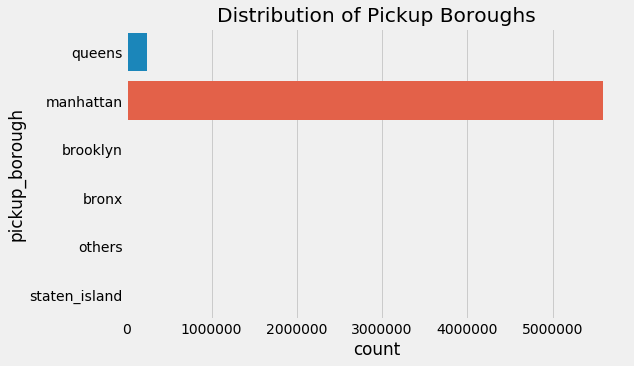

In [61]:
plt.figure(figsize=(8,5))
sns.countplot(y = train['pickup_borough'])
plt.title("Distribution of Pickup Boroughs")

As we can see above, Manhattan has the largest number of trip whereas Queens has the lowest number of trips.

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


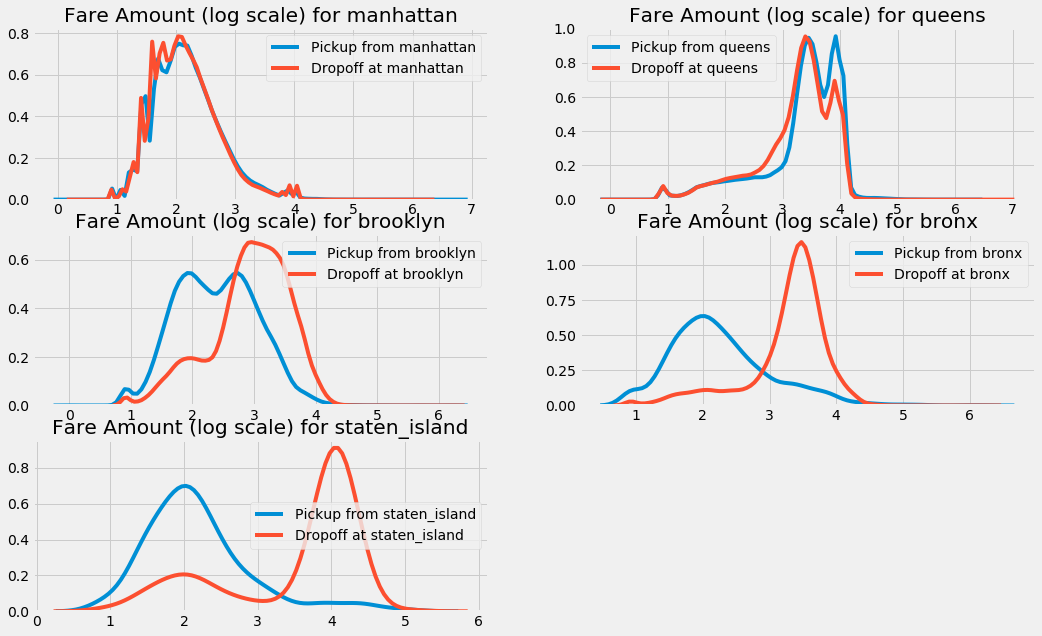

In [64]:
plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    log_pickup_borough = np.nan_to_num(np.log(train.loc[train['pickup_borough']==key,'fare_amount'].values))
    log_pickup_borough = log_pickup_borough[log_pickup_borough >= 0]
    
    log_dropoff_borough = np.nan_to_num(np.log(train.loc[train['dropoff_borough']==key,'fare_amount'].values))
    log_dropoff_borough = log_dropoff_borough[log_dropoff_borough >= 0]
    
    sns.kdeplot(log_pickup_borough,
                label = 'Pickup from '+ key)
    sns.kdeplot(log_dropoff_borough,
                label = 'Dropoff at '+ key).set_title("Fare Amount (log scale) for "+ key)
    
    i += 1

We conclude the following from the above graphs:

1. Pickup and dropoff fare amount are almost similarly distributed for Manhattan.
2. Dropoff fare amount has higher distribution for Staten Island and Bronx, which means trips to these two places are long.

In [65]:

lower_manhattan_boundary={
    'min_lng': -74.0194,
    'min_lat': 40.6997,           
    'max_lng': -73.9716,        
    'max_lat': 40.7427
}

def isLowerManhattan(lat,lng):
    """
    Check if lat and lng corresponds to lower manhattan
    Args:
        lat: Latitude
        lng: Longitude
    Returns:
        0 or 1 indicating whether the pick up or drop off location is in lower manhattan
    """
    if (lat >= lower_manhattan_boundary['min_lat'] and 
        lat <= lower_manhattan_boundary['max_lat'] and 
        lng >= lower_manhattan_boundary['min_lng'] and 
        lng <= lower_manhattan_boundary['max_lng']):
        return 1
    else:
        return 0

In [66]:
train['is_pickup_in_lower_manhattan'] = train.apply(lambda record: 
                                                    isLowerManhattan(
                                                        record['pickup_latitude'],
                                                        record['pickup_longitude']),axis=1)
train['is_dropoff_in_lower_manhattan'] = train.apply(lambda record: 
                                                     isLowerManhattan(
                                                         record['dropoff_latitude'],
                                                         record['dropoff_longitude']),axis=1)

In [69]:
print("The training data set now looks as follows\n")
print("--------------------------------------------")
train.head()

The training data set now looks as follows

--------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,...,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_LaGuardia,is_dropoff_LaGuardia,trip_distance,pickup_borough,dropoff_borough,is_pickup_in_lower_manhattan,is_dropoff_in_lower_manhattan
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,...,0,0,0,0,0,0.640487,queens,queens,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,...,0,0,0,0,0,5.250670,manhattan,manhattan,1,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,...,0,0,0,0,0,0.863411,manhattan,manhattan,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,...,0,0,0,0,0,1.739386,manhattan,manhattan,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,...,0,0,0,0,0,1.242218,manhattan,manhattan,0,0


### Analysis for fare amount based on whether pick up or drop off location is in lower Manhattan or in rest of Manhattan

In [70]:
# Select all trips in Manhattan
manhattan = train.loc[(train['pickup_borough'] == 'manhattan') | 
                      (train['dropoff_borough'] == 'manhattan')]
print("Number of trips in Manhattan = ", manhattan.shape[0])

Number of trips in Manhattan =  5778827


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

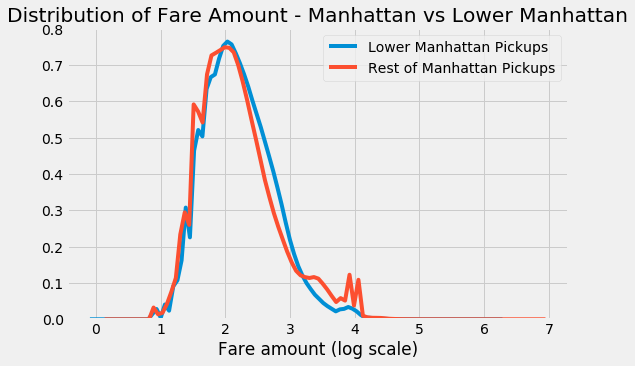

In [72]:
plt.figure(figsize=(8,5))

# Get all locations in lower manhattan
log_loc_lower_manhattan = np.nan_to_num(np.log(manhattan.loc[manhattan['is_pickup_in_lower_manhattan'] == 1,
                                                        'fare_amount'].values))
log_loc_lower_manhattan = log_loc_lower_manhattan[log_loc_lower_manhattan >= 0]

# Get all locations outside lower manhattan
log_not_loc_lower_manhattan = np.nan_to_num(np.log(manhattan.loc[manhattan['is_pickup_in_lower_manhattan'] == 0,
                                                        'fare_amount'].values))
log_not_loc_lower_manhattan = log_not_loc_lower_manhattan[log_not_loc_lower_manhattan >= 0]
    
sns.kdeplot(log_loc_lower_manhattan, 
            label='Lower Manhattan Pickups')
sns.kdeplot(log_not_loc_lower_manhattan,
            label='Rest of Manhattan Pickups')

plt.xlabel("Fare amount (log scale)")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

So, the distribution of fare is almost the same for trips in lower Manhattan and rest of Manhattan.

Let's try to visualise trip distance vs fare amount for pick ups in lower Manhattan.

Text(0.5,1,'Trip Distance vs Fare Amount (Lower Manhattan pickups)')

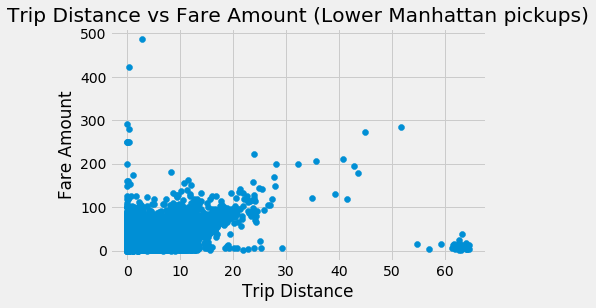

In [74]:
plt.scatter(x = manhattan.loc[manhattan['is_pickup_in_lower_manhattan'] == 1,'trip_distance'].values,
            y = manhattan.loc[manhattan['is_pickup_in_lower_manhattan'] == 1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan pickups)")

Let's try to visualise trip distance vs fare amount for pick ups in rest of Manhattan.

Text(0.5,1,'Trip Distance vs Fare Amount (Rest of Manhattan pickups)')

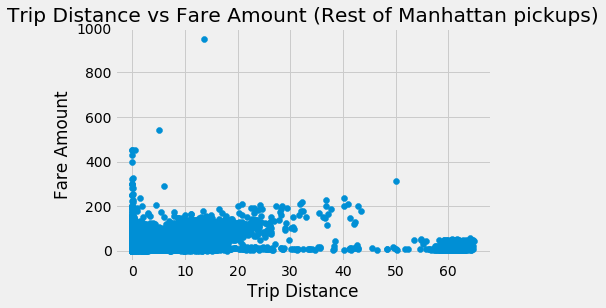

In [75]:
plt.scatter(x = manhattan.loc[manhattan['is_pickup_in_lower_manhattan'] == 0,'trip_distance'].values,
            y = manhattan.loc[manhattan['is_pickup_in_lower_manhattan'] == 0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan pickups)")

Let's try to visualise trip distance vs fare amount for drop offs in lower Manhattan.

By comparing the above two scatter plots, we conclude that the slope for linear relationship is higher for lower Manhattan than for Rest of Manhattan. So, the trips cost relatively lower for the same distance in rest of Manhattan.

Text(0.5,1,'Trip Distance vs Fare Amount (Lower Manhattan dropoffs)')

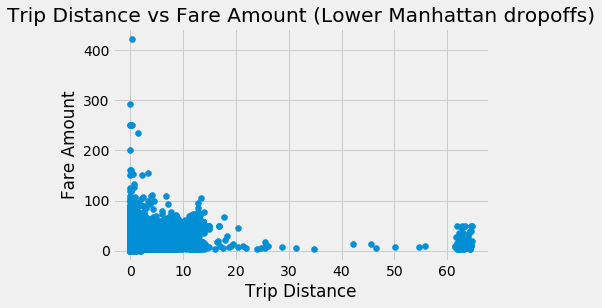

In [76]:
plt.scatter(x = manhattan.loc[manhattan['is_dropoff_in_lower_manhattan'] == 1,'trip_distance'].values,
            y = manhattan.loc[manhattan['is_dropoff_in_lower_manhattan'] == 1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan dropoffs)")

Let's try to visualise trip distance vs fare amount for drop offs in rest of Manhattan.

Text(0.5,1,'Trip Distance vs Fare Amount (Rest of Manhattan dropoffs)')

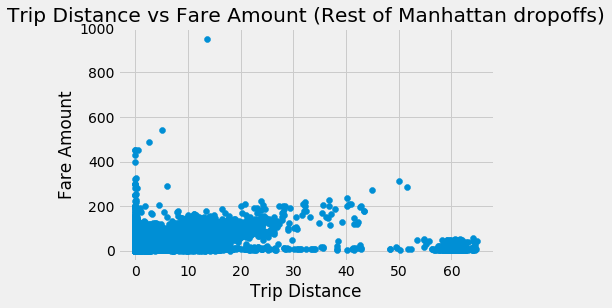

In [77]:
plt.scatter(x = manhattan.loc[manhattan['is_dropoff_in_lower_manhattan'] == 0,'trip_distance'].values,
            y = manhattan.loc[manhattan['is_dropoff_in_lower_manhattan'] == 0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan dropoffs)")

There is not much to compare in the drop off scatter plots for lower Manhattan and rest of Manhattan.

### Analysis for fare amount based on date and time features

Text(0.5,1,'Trips per year')

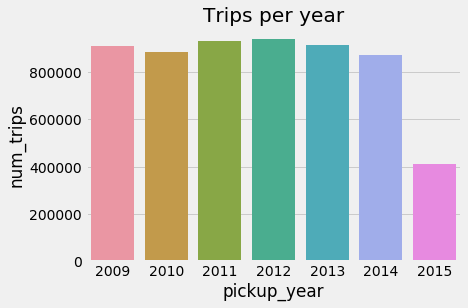

In [84]:
trips_per_year = train.groupby(['pickup_year'])['key'].count().reset_index().rename(columns={'key': 'num_trips'})
trips_per_year.head()
sns.barplot(x = 'pickup_year',
            y = 'num_trips',
            data = trips_per_year).set_title("Trips per year")

Here we conclude that the most number of trips were in the years 2011 and 2012, both more than 0.8M.

Text(0.5,1,'Avg fare amount per year')

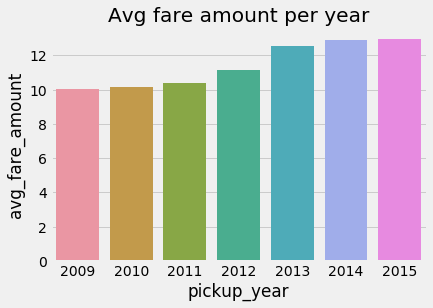

In [83]:
avg_trip_fare_amount_per_year = train.groupby(['pickup_year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

sns.barplot(x = 'pickup_year',
            y = 'avg_fare_amount',
            data = avg_trip_fare_amount_per_year).set_title("Avg fare amount per year")

Here we conclude that the average fare price continues to increase over the years.

In [85]:
def group_and_plot(data, groupby_key, value, aggregate='mean'):
    """
    Helper function to group and plot data
    Args:
        data: Data to plot
        groupby_key: Key to group by
        value: Column name on which to perform aggregation
        aggregate: Name of the aggregation function to use
    """
    plt.figure(figsize=(16,10))
    agg_data = data.groupby([groupby_key])[value]\
                .agg(aggregate).reset_index()\
                .rename(columns={value: aggregate + '_' + value})
    
    plt.subplot(1,2,1)
    count_data = train.groupby([groupby_key])['key'].count()\
                .reset_index().rename(columns={'key': 'num_trips'})
    
    sns.barplot(x = groupby_key,
                y = 'num_trips',
                data = count_data).set_title("Number of Trips vs " + groupby_key)
    
    plt.subplot(1,2,2)
    sns.barplot(x = groupby_key,
                y = aggregate + '_' + value,
                data = agg_data).set_title(aggregate + '_' + value + " vs " + groupby_key)

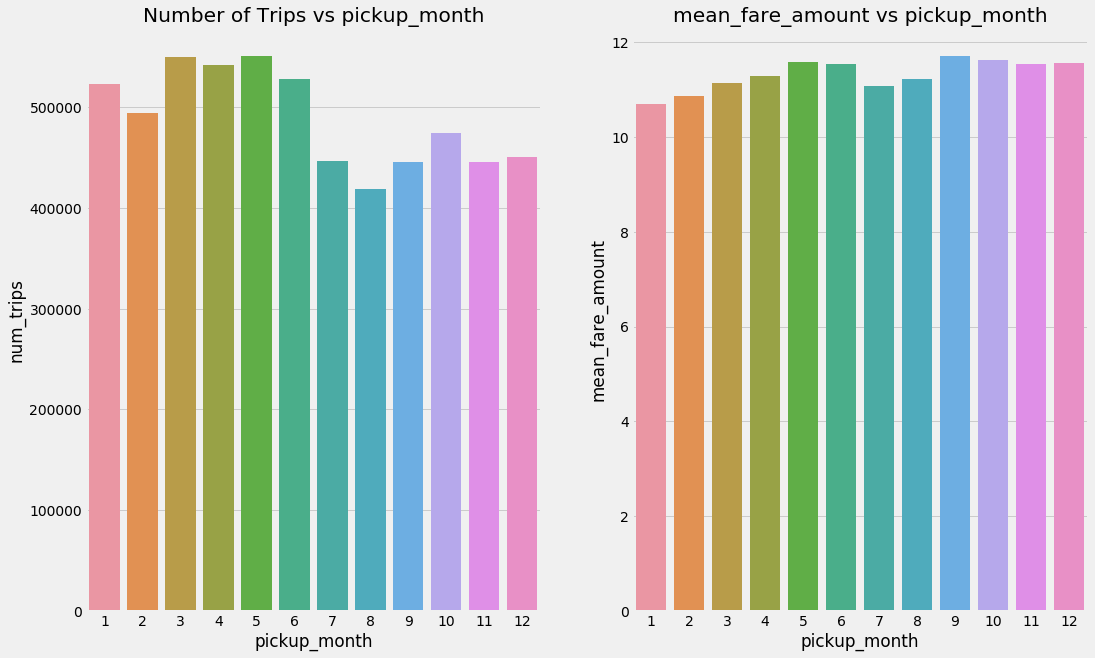

In [86]:
group_and_plot(train, 'pickup_month', 'fare_amount')

Conclusion:
1. Number of trips are lower from June till December
2. Trips are more in the months of March and May.
3. Fares across months are fairly constant.

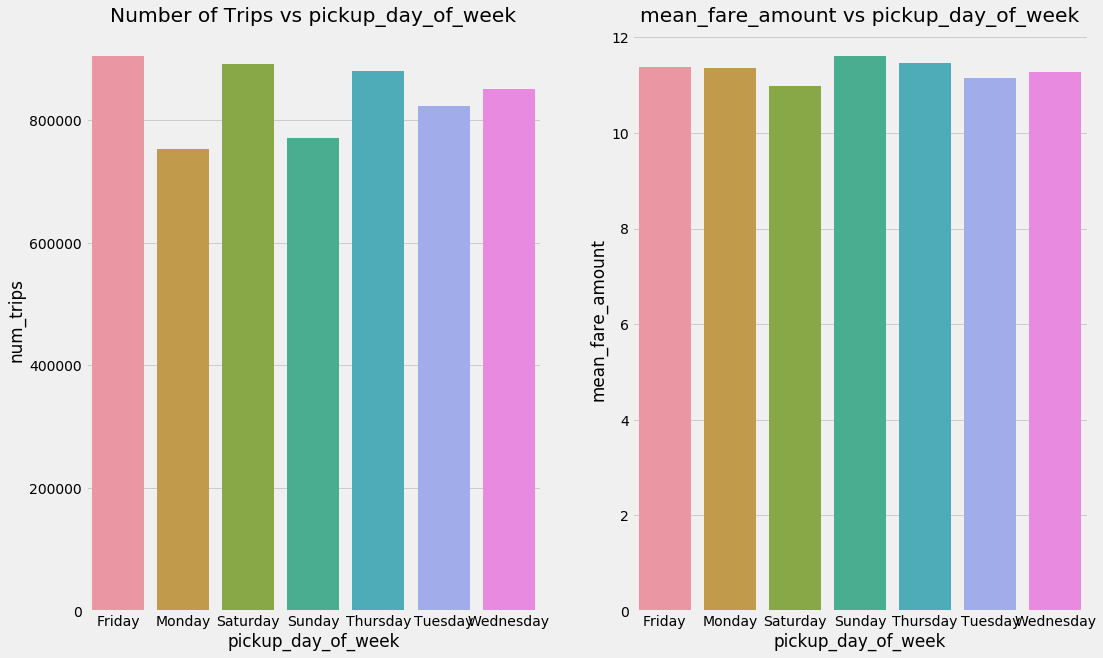

In [87]:
group_and_plot(train, 'pickup_day_of_week', 'fare_amount')

Conclusion:

1. Saturday has lowest average fare amount and also Saturday has the highest number of trips.
2. On Monday and Sunday, the number of trips are low, but the average fare amounts are higher.

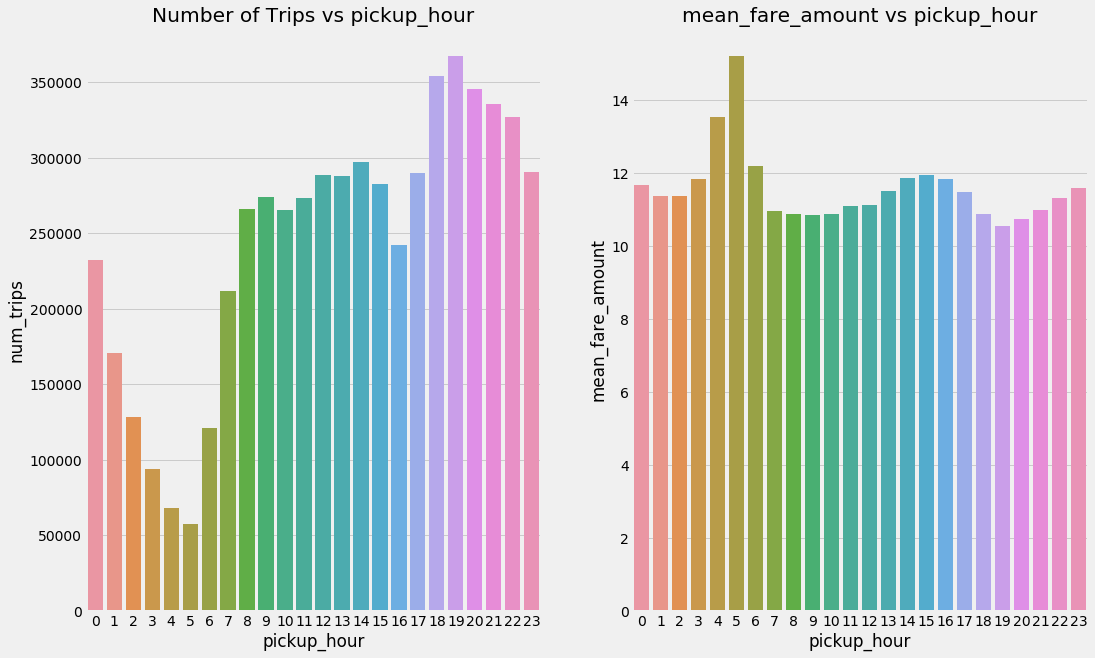

In [88]:
group_and_plot(train, 'pickup_hour', 'fare_amount')

Conclusion:
1. The number of trips are least at 5 am in the morning but the average fare amounts are the highest at the same time.
2. Between 1 am to 5 am the number of trips decrease and the average fare amounts increase.
3. The highest number of trips are at 6 pm and 7 pm but the average fare amounts are the lowest.

In [91]:
def encode_days(day_of_week):
    """
    Encode days of the week in numbers
    Args:
        day_of_week: Number representing day of the week
    Returns:
        Day of the week by name
    """
    day_dict={
        'Sunday': 0,
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6
    }
    return day_dict[day_of_week]

In [93]:
train['pickup_day_of_week'] = train['pickup_day_of_week'].apply(lambda x: encode_days(x))

In [94]:
print("The training data set now looks as follows\n")
print("--------------------------------------------")
train.head()

The training data set now looks as follows

--------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,...,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_LaGuardia,is_dropoff_LaGuardia,trip_distance,pickup_borough,dropoff_borough,is_pickup_in_lower_manhattan,is_dropoff_in_lower_manhattan
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,...,0,0,0,0,0,0.640487,queens,queens,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,...,0,0,0,0,0,5.250670,manhattan,manhattan,1,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,...,0,0,0,0,0,0.863411,manhattan,manhattan,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,...,0,0,0,0,0,1.739386,manhattan,manhattan,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,...,0,0,0,0,0,1.242218,manhattan,manhattan,0,0


### Analysis for fare amount based on number of passengers

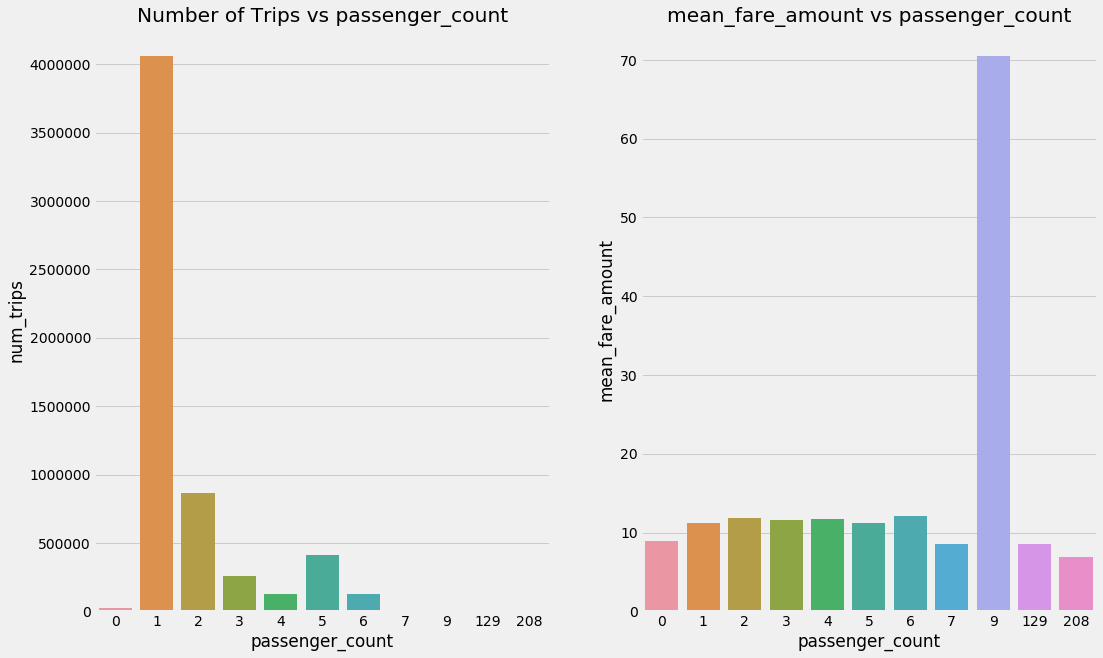

In [95]:
group_and_plot(train, 'passenger_count', 'fare_amount')

In [102]:
print("Trips with 0 passengers = ", train.loc[train['passenger_count'] == 0].shape[0])
print("Trips with 9 passengers = ", train.loc[train['passenger_count'] == 9].shape[0])
print("Trips with 129 passengers = ", train.loc[train['passenger_count'] == 129].shape[0])
print("Trips with 208 passengers = ", train.loc[train['passenger_count'] == 208].shape[0])

print('\n\n')

print("Trips with 9 passengers in test data = ", test.loc[test['passenger_count'] == 9].shape[0])
print("Trips with less than 9 passengers in test data = ", test.loc[test['passenger_count'] <= 9].shape[0])

Trips with 0 passengers =  20719
Trips with 9 passengers =  2
Trips with 129 passengers =  1
Trips with 208 passengers =  2



Trips with 9 passengers in test data =  0
Trips with less than 9 passengers in test data =  9914


CONCLUSION:
1. There are 20719 trips where number of passengers is 0. But we see all of the trips have a fare amount more than 0. This means it would be like the passenger was charged cancellation fee in which case pick up and drop off location remains same.
2. The price is highest when there are 9 passengers and only two such records exist.
3. Trips with 129 and 208 passengers are definitely outliers.
4. The maximum number of passenger count in the test data is 8 per trip. So, we can safely remove all trips with passenger count more than 8 from the training data set.

In [103]:
train = train[train['passenger_count'] <= 8]

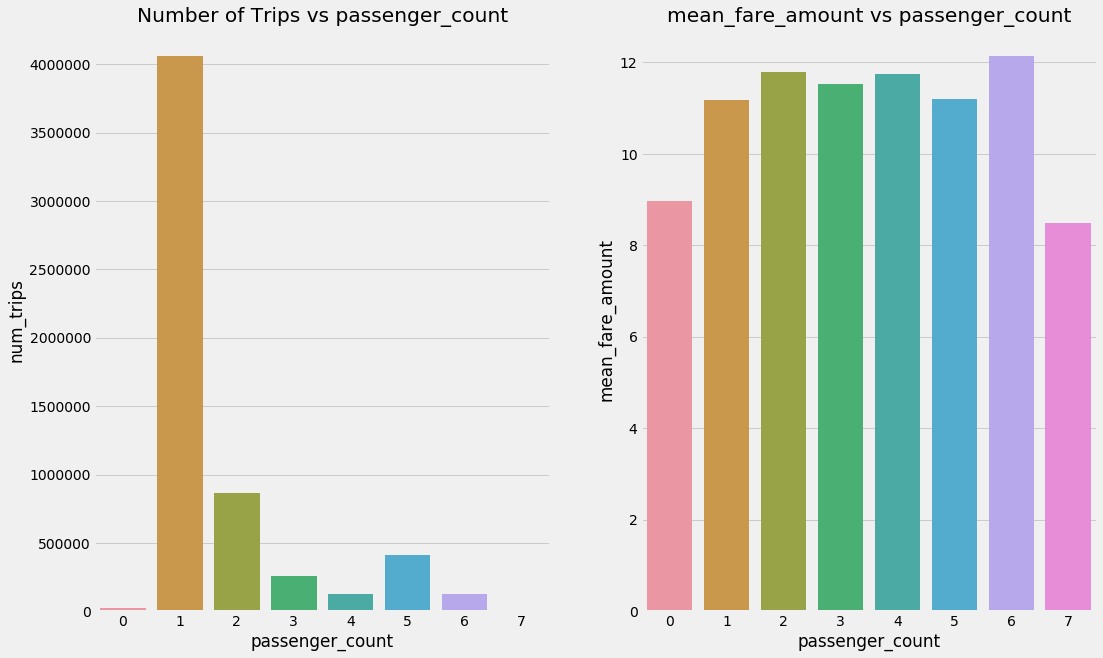

In [104]:
group_and_plot(train, 'passenger_count', 'fare_amount')

Fare amount is highest for 6 passengers and lowest for 7 passengers.

In [105]:
train.to_csv("./data/train_cleaned.csv",index=False)

In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5871405 entries, 0 to 5999999
Data columns (total 25 columns):
key                              object
fare_amount                      float64
pickup_datetime                  datetime64[ns]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  int64
pickup_date                      object
pickup_day                       int64
pickup_hour                      int64
pickup_day_of_week               int64
pickup_month                     int64
pickup_year                      int64
is_pickup_JFK                    int64
is_dropoff_JFK                   int64
is_pickup_EWR                    int64
is_dropoff_EWR                   int64
is_pickup_LaGuardia              int64
is_dropoff_LaGuardia             int64
trip_distance                    float64
pickup_borough                   object
dropo

### Cleaning of test data set

In [109]:
test =  pd.read_csv('./data/test.csv')
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'],
                                         format='%Y-%m-%d %H:%M:%S UTC')

test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].apply(lambda x: x.day)
test['pickup_hour'] = test['pickup_datetime'].apply(lambda x: x.hour)
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
test['pickup_month'] = test['pickup_datetime'].apply(lambda x: x.month)
test['pickup_year'] = test['pickup_datetime'].apply(lambda x: x.year)
test['is_pickup_JFK'] = test.apply(lambda record: 
                                   isTripRelatedToAirport(record['pickup_latitude'],
                                             record['pickup_longitude'],'JFK'),axis=1)
test['is_dropoff_JFK'] = test.apply(lambda record:
                                    isTripRelatedToAirport(record['dropoff_latitude'],
                                              record['dropoff_longitude'],'JFK'),axis=1)
test['is_pickup_EWR'] = test.apply(lambda record: 
                                   isTripRelatedToAirport(record['pickup_latitude'],
                                             record['pickup_longitude'],'EWR'),axis=1)
test['is_dropoff_EWR'] = test.apply(lambda record:
                                    isTripRelatedToAirport(record['dropoff_latitude'],
                                              record['dropoff_longitude'],'EWR'),axis=1)
test['is_pickup_LaGuardia'] = test.apply(lambda record:
                                          isTripRelatedToAirport(record['pickup_latitude'],
                                                    record['pickup_longitude'],'LaGuardia'),axis=1)
test['is_dropoff_LaGuardia'] = test.apply(lambda record:
                                           isTripRelatedToAirport(record['dropoff_latitude'],
                                                     record['dropoff_longitude'],'LaGuardia'),axis=1)
test['trip_distance'] = test.apply(lambda record: 
                                   trip_distance(record['pickup_latitude'],
                                            record['dropoff_latitude'],
                                            record['pickup_longitude'],
                                            record['dropoff_longitude']),axis=1)
test['pickup_borough'] = test.apply(lambda record: 
                                    getBorough(record['pickup_latitude'],
                                               record['pickup_longitude']),axis=1)
test['dropoff_borough'] = test.apply(lambda record:
                                     getBorough(record['dropoff_latitude'],
                                                record['dropoff_longitude']),axis=1)
test['is_pickup_in_lower_manhattan'] = test.apply(lambda record:
                                                  isLowerManhattan(record['pickup_latitude'],
                                                        record['pickup_longitude']),axis=1)
test['is_dropoff_in_lower_manhattan']=test.apply(lambda record:
                                                 isLowerManhattan(record['dropoff_latitude'],
                                                        record['dropoff_longitude']),axis=1)
test['pickup_day_of_week'] = test['pickup_day_of_week'].apply(lambda x: encode_days(x))
print("Shape of test data", test.shape)

test.to_csv("./data/test_cleaned.csv",index=False)

Shape of test data (9914, 24)
